# Decision Tree Regression

This notebook trains and evaluates a Decision Tree regression model
to predict flight prices using the processed dataset.

## 0. Import Libraries

In [11]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt

## 1. Load Processed Data

In [13]:
DATA_PATH = "../data/processed/flight_prices_processed.csv"
df = pd.read_csv(DATA_PATH)

df.shape, df.columns
df.head()

,Airline,Source,Destination,Total_Stops,Price,Price_USD,Duration_min,Journey_day,Journey_month,Dep_hour,Dep_min,Arr_hour,Arr_min
0,IndiGo,Banglore,New Delhi,0,3897,46.764,170,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,2,7662,91.944,445,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,2,13882,166.584,1140,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,1,6218,74.616,325,12,5,18,5,23,30
4,IndiGo,Banglore,New Delhi,1,13302,159.624,285,1,3,16,50,21,35


## 2. Define X / y

In [14]:
target = "Price_USD"
drop_cols = ["Price_USD", "Price"] 

X = df.drop(columns=drop_cols, errors="ignore")
y = df[target]

## 3. Train/Test Split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## 4. Preprocess

In [16]:
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median"))
        ]), num_cols),
    ],
    remainder="drop",
)

## 5. Baseline Decision Tree

In [17]:
tree_reg = DecisionTreeRegressor(
    random_state=123,
    max_depth=4
)

pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", tree_reg)
])

pipe.fit(X_train, y_train)

pred = pipe.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, pred))
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)

print({"rmse": rmse, "mae": mae, "r2": r2})

{'rmse': np.float64(33.60241495457917), 'mae': 23.281047093213136, 'r2': 0.604100197808874}


## 6. GridSearch

In [18]:
param_grid_dt = {
    "model__max_depth": [3, 4, 5, 6, 8, 10],
    "model__min_samples_split": [2, 5, 10, 20],
    "model__min_samples_leaf": [1, 2, 4, 8]
}

dt_grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid_dt,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

dt_grid.fit(X_train, y_train)

print("Best params:", dt_grid.best_params_)
print("Best CV RMSE:", -dt_grid.best_score_)

best_pipe = dt_grid.best_estimator_

Best params: {'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 10}
Best CV RMSE: 25.298958648798532


In [19]:
pred = best_pipe.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R2: {r2:.3f}")

Test RMSE: 26.43
Test R2: 0.755


## 7. Cost-Complexity Pruning

In [20]:
preprocess_fit = preprocess.fit(X_train)
X_train_trans = preprocess_fit.transform(X_train)

tree_max = DecisionTreeRegressor(
    random_state=123,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2
)
tree_max.fit(X_train_trans, y_train)

path = tree_max.cost_complexity_pruning_path(X_train_trans, y_train)
ccp_alphas = np.unique(path.ccp_alphas)
if len(ccp_alphas) > 1:
    ccp_alphas = ccp_alphas[:-1]

print("Number of candidate ccp_alphas:", len(ccp_alphas))

Number of candidate ccp_alphas: 360


In [21]:
ccp_alphas = np.linspace(0.0, 0.005, 8)
cv = KFold(n_splits=3, shuffle=True, random_state=123)

records = []
for a in ccp_alphas:
    tree_a = DecisionTreeRegressor(random_state=123, ccp_alpha=a, max_depth=10)
    scores = cross_val_score(
        tree_a, X_train_trans, y_train,
        cv=cv, scoring="neg_root_mean_squared_error", n_jobs=-1
    )
    tree_a.fit(X_train_trans, y_train)
    records.append({
        "ccp_alpha": a,
        "mean_rmse": -scores.mean(),
        "std_rmse": scores.std(ddof=1),
        "depth": tree_a.get_depth(),
        "leaves": tree_a.get_n_leaves()
    })

alpha_df = pd.DataFrame(records).sort_values("ccp_alpha").reset_index(drop=True)
alpha_df

,ccp_alpha,mean_rmse,std_rmse,depth,leaves
0,0.000000,27.653690,1.506671,10,513
1,0.000714,27.650064,1.509739,10,482
2,0.001429,27.648918,1.510430,10,471
3,0.002143,27.652814,1.512370,10,466
4,0.002857,27.651460,1.514427,10,461
5,0.003571,27.652270,1.512259,10,458
6,0.004286,27.650774,1.513400,10,455
7,0.005000,27.654046,1.515240,10,451


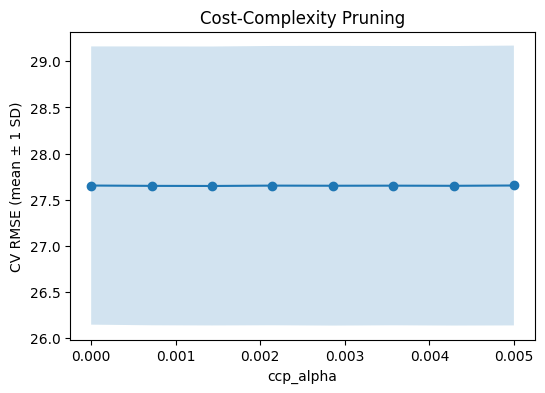

In [22]:
plt.figure(figsize=(6,4))
plt.plot(alpha_df["ccp_alpha"], alpha_df["mean_rmse"], marker="o")
plt.fill_between(
    alpha_df["ccp_alpha"],
    alpha_df["mean_rmse"] - alpha_df["std_rmse"],
    alpha_df["mean_rmse"] + alpha_df["std_rmse"],
    alpha=0.2
)
plt.xlabel("ccp_alpha")
plt.ylabel("CV RMSE (mean ± 1 SD)")
plt.title("Cost-Complexity Pruning")
plt.show()

In [23]:
best_idx = alpha_df["mean_rmse"].idxmin()
best_mean = alpha_df.loc[best_idx, "mean_rmse"]
best_sd = alpha_df.loc[best_idx, "std_rmse"]
threshold = best_mean + best_sd

eligible = alpha_df[alpha_df["mean_rmse"] <= threshold]
alpha_1se = eligible["ccp_alpha"].max()

print("Best mean CV RMSE:", best_mean, "at alpha=", alpha_df.loc[best_idx, "ccp_alpha"])
print("1-SE threshold:", threshold)
print("Selected alpha by 1-SE rule:", alpha_1se)

Best mean CV RMSE: 27.64891848100372 at alpha= 0.0014285714285714286
1-SE threshold: 29.15934896781625
Selected alpha by 1-SE rule: 0.005


In [24]:
X_train_trans = preprocess_fit.transform(X_train)
X_test_trans = preprocess_fit.transform(X_test)

tree_final = DecisionTreeRegressor(
    random_state=123,
    ccp_alpha=alpha_1se,
    max_depth=10
)
tree_final.fit(X_train_trans, y_train)

pred = tree_final.predict(X_test_trans)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R2: {r2:.3f}")

Test RMSE: 25.38
Test R2: 0.774


## 8. Predicted vs Actual Plot

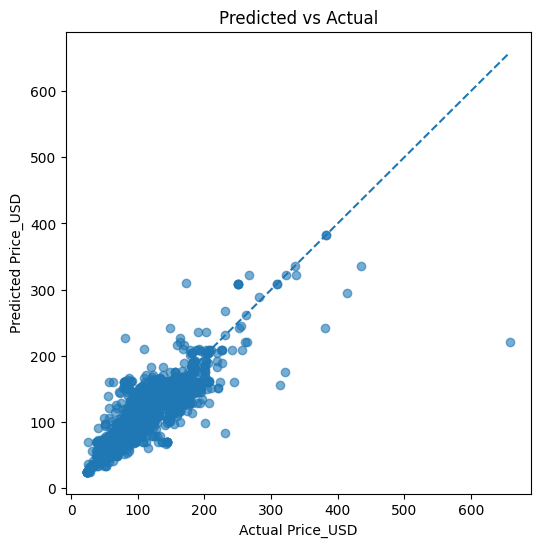

In [25]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, pred, alpha=0.6)
mn, mx = y_test.min(), y_test.max()
plt.plot([mn, mx], [mn, mx], linestyle="--")
plt.xlabel("Actual Price_USD")
plt.ylabel("Predicted Price_USD")
plt.title("Predicted vs Actual")
plt.show()

## 9. Featrure Importance Plot

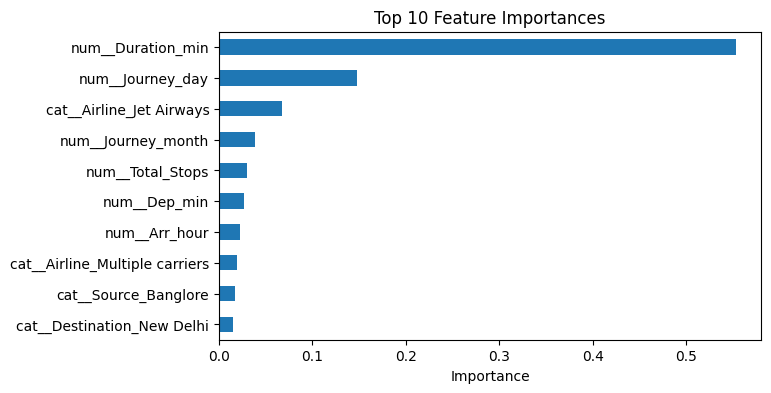

In [26]:
feature_names = preprocess_fit.get_feature_names_out()

fi = pd.Series(tree_final.feature_importances_, index=feature_names).sort_values(ascending=False)
top_n = 10
fi.head(top_n).sort_values().plot(kind="barh", figsize=(7,4))
plt.title(f"Top {top_n} Feature Importances")
plt.xlabel("Importance")
plt.show()

## 10. Example Prediction

In [27]:
new_flight = pd.DataFrame([{
    "Airline": "IndiGo",
    "Source": "Delhi",
    "Destination": "Cochin",
    "Total_Stops": 1,
    "Duration_min": 155,
    "Journey_day": 12,
    "Journey_month": 11,
    "Dep_hour": 15,
    "Dep_min": 25,
    "Arr_hour": 17,
    "Arr_min": 40
}])

new_trans = preprocess_fit.transform(new_flight)
pred_price = tree_final.predict(new_trans)[0]
print(f"Predicted price (USD): {pred_price:.2f}")

Predicted price (USD): 44.87


## 11. Summary

- A Decision Tree model was used to capture nonlinear pricing patterns.
- Pruning was applied to control overfitting and improve generalization.
- Despite improved flexibility, the model remains sensitive to variance.